# 3.2 Clustering analysis and PCA (on normalized count data)#

### IMPORTANT: Please make sure that you are using the R kernel to run this notebook.###
We are now switching from the bash kernel to the R kernel. 
The R language provides a number of utilities for genomic data analysis and visualization. We will explore some of these. 

In [8]:
#The preprocessCore library provides a number of functions useful for statistical analysis,
#including functions for data normalization that we will use below. 
library("preprocessCore")

In [9]:
?library

In [47]:
#Change to your $WORK_DIR. The syntax for switching directories in R is a little different than what we used in bash. 
#Use the "setwd" command to switch to your $WORK_DIR 
sunetid="soumyak"
work_dir=paste("/scratch/",sunetid,sep="")
setwd(work_dir)
#The "dir" command will list all files in your current working directory 
dir()

[1] "all_peaks.togene.txt"                             
[2] "data"                                             
[3] "pc1_contribs.txt"                                 
[4] "pc2_contribs.txt"                                 
[5] "pc3_contribs.txt"                                 
[6] "src"                                              
[7] "tmp"                                              
[8] "WT_0min_vs_45min.differential.negative.togene.txt"
[9] "WT_0min_vs_45min.differential.positive.togene.txt"

In this tutorial we will focus on the clustering and PCA analysis steps of the pipeline: 
![Analysis pipeline](images/part3.png)

In [48]:
#load the count signal matrix. You can either use the one you generated in the last tutorial,or the one that we have 
#pre-generated in the $AGGREGATE_ANALYSIS_DIR folder in case you ran into any issues with that step

#count_data=read.table("all.count.txt",header=TRUE)
count_data=read.table("/outputs/all.readcount.txt",header=TRUE)

rownames(count_data)=paste(count_data$Chrom,count_data$Start,count_data$End,sep='\t')
#remove the columns we will not use in downstream analysis
count_data$ID=NULL
count_data$Chrom=NULL
count_data$Start=NULL
count_data$End=NULL

head(count_data)

,X0min_YAP6_1,X45min_HOT1_2,X0min_HOG1_1,X45min_WT_2,X0min_YAP1_2,X45min_YAP6_2,X0min_MSN2_2,X45min_YAP7_1,X0min_MSN4_2,X45min_MSN2_2,⋯,X0min_HOT1_2,X45min_YAP1_2,X0min_WT_2,X45min_MSN2_1,X0min_MSN2_1,X45min_YAP6_1,X0min_YAP7_2,X45min_HOT1_1,X0min_YAP6_2,X45min_YAP7_2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chrI 13 555,451,289,140,72,59,16,104,43,74,17,⋯,30,93,49,90,138,356,8,1687,20,576
chrI 6348 6518,41,36,16,14,11,4,15,2,18,1,⋯,2,33,11,22,19,65,4,428,6,243
chrI 9278 9407,21,29,4,1,0,6,3,3,2,0,⋯,0,22,3,7,3,20,0,95,6,179
chrI 19401 19705,14,25,5,3,10,2,5,0,1,0,⋯,0,29,5,15,1,25,2,210,3,435
chrI 20461 21224,271,467,139,105,86,13,147,66,109,23,⋯,29,351,62,140,125,437,19,3508,57,1462
chrI 28565 28910,141,73,67,19,26,4,74,3,60,15,⋯,9,88,23,35,62,127,7,739,15,378


In [49]:
#normalize the data 
#quantile normalization 
norm_asinh_count=normalize.quantiles(data.matrix(asinh(count_data)))

In [50]:
colnames(norm_asinh_count)=names(count_data)
rownames(norm_asinh_count)=rownames(count_data)

In [51]:
head(norm_asinh_count)

,X0min_YAP6_1,X45min_HOT1_2,X0min_HOG1_1,X45min_WT_2,X0min_YAP1_2,X45min_YAP6_2,X0min_MSN2_2,X45min_YAP7_1,X0min_MSN4_2,X45min_MSN2_2,⋯,X0min_HOT1_2,X45min_YAP1_2,X0min_WT_2,X45min_MSN2_1,X0min_MSN2_1,X45min_YAP6_1,X0min_YAP7_2,X45min_HOT1_1,X0min_YAP6_2,X45min_YAP7_2
chrI 13 555,5.641093,5.214142,5.242196,5.116951,4.9676781,4.907491,5.116951,5.214142,5.010445,4.853489,⋯,5.665892,4.647339,5.037273,4.892705,5.459623,5.252684,4.035811,4.860972,4.493831,4.352533
chrI 6348 6518,3.356586,3.203066,3.149658,3.623361,3.0584121,3.460160,3.230137,2.418101,3.681175,2.594748,⋯,2.920447,3.448887,3.483455,3.456380,3.558182,3.609176,3.334077,3.484213,3.180575,3.272790
chrI 9278 9407,2.530541,2.955979,1.763698,1.515142,0.6867803,3.849143,1.615106,2.760025,1.685203,1.903557,⋯,1.822549,2.909270,2.234225,1.904405,1.772880,2.103851,1.697666,1.327813,3.180575,2.774711
chrI 19401 19705,1.982673,2.772091,1.903731,2.234316,2.9513789,2.886685,2.029322,1.331892,1.329129,1.903557,⋯,1.822549,3.282781,2.678882,3.009042,1.229407,2.485274,2.785971,2.527995,2.580103,4.023502
chrI 20461 21224,5.175706,5.677917,5.236512,5.443495,5.3754231,4.697929,5.492460,5.614217,5.360715,5.128764,⋯,5.622283,6.061645,5.278192,5.363173,5.369287,5.450725,5.054830,5.639928,5.717778,5.471197
chrI 28565 28910,4.574218,3.949534,4.523146,3.896774,4.0374117,3.460160,4.788231,2.760025,4.800611,4.726170,⋯,4.288996,4.578360,4.245313,3.947218,4.703763,4.244682,3.901598,4.066436,4.162863,3.855110


Much better! After quantile normalization, the count values across samples are on the same scale. 

## PCA ##

PCA (Principal Component Analysis) is a way to identify the primary directions of variation in the data. It can also be used for very coarse-grained clustering of samples; similar samples will have similar coordinates along the principal axes.

We will perform PCA on *all.count.txt*. We treat each sample as a single point in a very high dimensional space (where the dimensionality is equal to the number of genes the vary), and then we will perform dimensionality reduction in this space. We can color-code the PCA plots by "Strain", "Timepoint", "Researcher", or "Sample" to determine which parameter separates the samples most effectively. 

In [52]:
#We run the principle component analysis command in R

#The t() function transposes the data matrix and allows us to cluster the samples, as opposed to the individual peaks,
#by placing the samples in the rows and the peaks in the columns. 
count.pca=prcomp(t(norm_asinh_count))

We generate a scree plot that shows how much variance in the data is explained by each prinicipal component:

In [53]:
var_explained=round(100*count.pca$sdev^2/sum(count.pca$sdev^2),2)
print(var_explained)

 [1] 9.87 6.21 5.34 4.21 4.08 3.89 3.76 3.68 3.38 3.34 3.16 3.03 2.99 2.86 2.85
[16] 2.74 2.53 2.34 2.29 2.22 2.14 1.99 1.93 1.83 1.78 1.70 1.61 1.52 1.47 1.42
[31] 1.21 1.18 1.08 1.05 0.92 0.84 0.71 0.46 0.37 0.00


Let's generate a simple bar graph to better illustrate the variance explained by each PC.


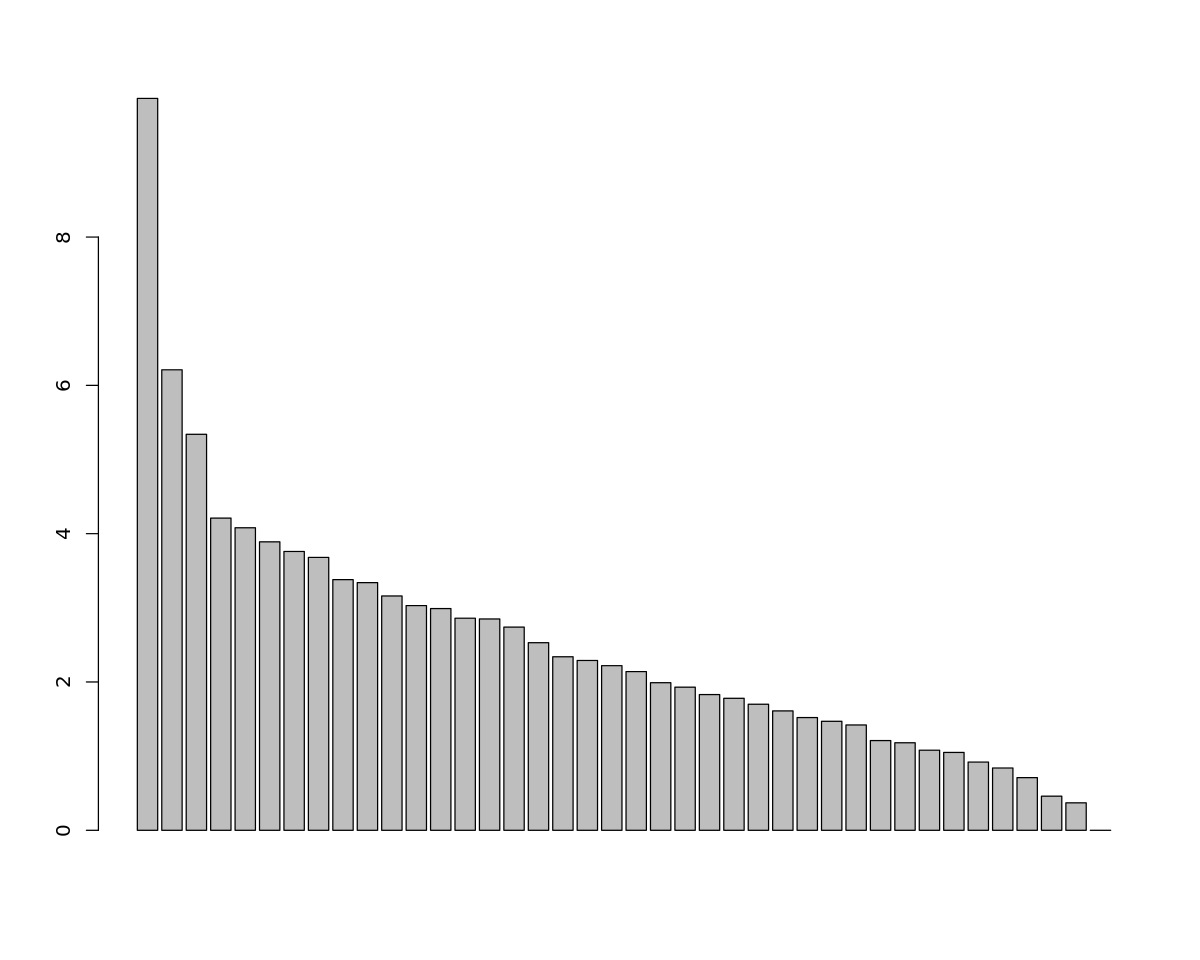

In [54]:
barplot(var_explained)

We can also plot the first few prinicpal components to see if they correlate with any of our experimental variables: 

    * Strain of yeast 
    * Timepoint 
    
We also expect replicates for the same sample to cluster closely together.

Finally, we should make sure to check for any unintended batch effects in the data. For example, it's posssible that samples generated by one researcher may exhibit a systematic difference from samples generated by a different researcher. We should check for this bias and correct it if possible. 


    

In [55]:
metadata=read.table("/metadata/TC2020_samples.tsv",header=TRUE)
nrow(metadata)

[1] 40

In [56]:
#First, we load our metadata file into R to help us color samples by replicate, strain, timepoint, and researcher. 
metadata=read.table("/metadata/TC2020_samples.tsv",header=TRUE)
#We use the "factor" function to tell R which variables are categorical rather than continuous 
metadata$Strain=factor(metadata$Strain)
metadata$Timepoint=factor(metadata$Timepoint)
metadata$Sample=factor(metadata$Sample)
metadata$GeneratedByResearcher=factor(metadata$GeneratedByResearcher)
metadata$GeneratedByGroup=factor(metadata$GeneratedByGroup)


#we modify the ID column by pre-facing it with an X to generate valid R index names (this column will be used as an index column in PCA analysis)
metadata$ID=make.names(metadata$ID)
head(metadata)

,Sample,AssignedTo,Timepoint,Strain,Replicate,ID,GeneratedByResearcher,GeneratedByGroup
,<fct>,<chr>,<fct>,<fct>,<int>,<chr>,<fct>,<fct>
1,0min_HOG1,meenakshi,0min,HOG1,1,X0min_HOG1_1,2,genetics
2,0min_HOG1,meenakshi,0min,HOG1,2,X0min_HOG1_2,13,genetics
3,0min_HOT1,ben,0min,HOT1,1,X0min_HOT1_1,14,genetics
4,0min_HOT1,ben,0min,HOT1,2,X0min_HOT1_2,16,compsci
5,0min_MSN1,usman,0min,MSN1,1,X0min_MSN1_1,15,genetics
6,0min_MSN1,usman,0min,MSN1,2,X0min_MSN1_2,7,genetics


In [57]:
#extract the PC columns from the count.pca object 
pcs=data.frame(count.pca$x)
head(pcs)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X0min_YAP6_1,-18.3170115,-4.795875,1.1586480,-3.4791238,1.6332603,-0.07800794,-3.936076,1.796056,-2.3645296,1.260409,⋯,1.8408770,1.7922190,-6.3472833,3.07696955,3.31075113,-10.0510575,5.29149848,-0.1979773,1.7382409,1.196265e-14
X45min_HOT1_2,0.7048794,-5.835027,5.7617865,0.4048014,2.9107955,0.72994240,-2.501545,-1.468747,-3.2584685,-1.353397,⋯,-1.0916162,-8.8108942,8.7243195,-2.91687127,-4.28709542,-0.1747029,-0.34839789,0.2446362,-0.6598279,1.329492e-14
X0min_HOG1_1,-10.2680792,-5.380289,1.9961903,0.2145198,-0.6198607,-0.60664045,-1.360889,-1.190110,0.3142684,-1.191786,⋯,-18.4648135,-1.6554646,0.3639658,1.48334083,0.79247521,-0.8308033,0.08756869,1.1035770,0.6375330,1.003364e-14
X45min_WT_2,9.7303811,-6.054440,0.3428657,-0.4976589,-1.2407059,0.13759686,-3.271953,-2.592916,2.3274845,-1.400454,⋯,0.8057454,-1.9077883,-1.0183525,1.92998552,-0.61282973,-0.3786356,-0.44333730,0.1606404,-0.2175736,1.337819e-14
X0min_YAP1_2,-3.4670706,8.459236,7.3550000,-0.5490373,-3.9126370,-1.17380182,2.439041,3.630144,1.4474908,-2.151028,⋯,-0.9308081,0.3468232,-0.3884809,-0.47444635,1.41123967,0.3247524,-0.36789706,0.2879282,0.0851277,1.424555e-14
X45min_YAP6_2,5.5245534,19.868625,-10.9387079,-11.3682557,21.2693604,-14.63990457,-8.470538,-8.499427,-4.7970289,-9.997856,⋯,-0.3663903,0.4043823,-0.3135189,-0.04709901,0.09007073,0.2213441,-0.13383599,-0.4004708,0.1565258,1.135203e-14


In [58]:
#add columns from the metadata file. Do this safely using the "merge" command to make sure the sample ID's 
#from the two data frames are aligned
pcs$ID=rownames(pcs)
pcs_annotated=merge(pcs,metadata,by="ID")
nrow(pcs_annotated) #should be 40

[1] 40

Now, we can use the ggplot package in R to generate scatterplots of PC1 vs PC2, PC2 vs PC3, etc and color-code
by experimental variables. 


In [59]:
library(ggplot2)
## set universal plot size:
options(repr.plot.width=10, repr.plot.height=8)

In [60]:
#select 20 distinct colors to use for the PCA scatterplot. 
cols=c('#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928','#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f')

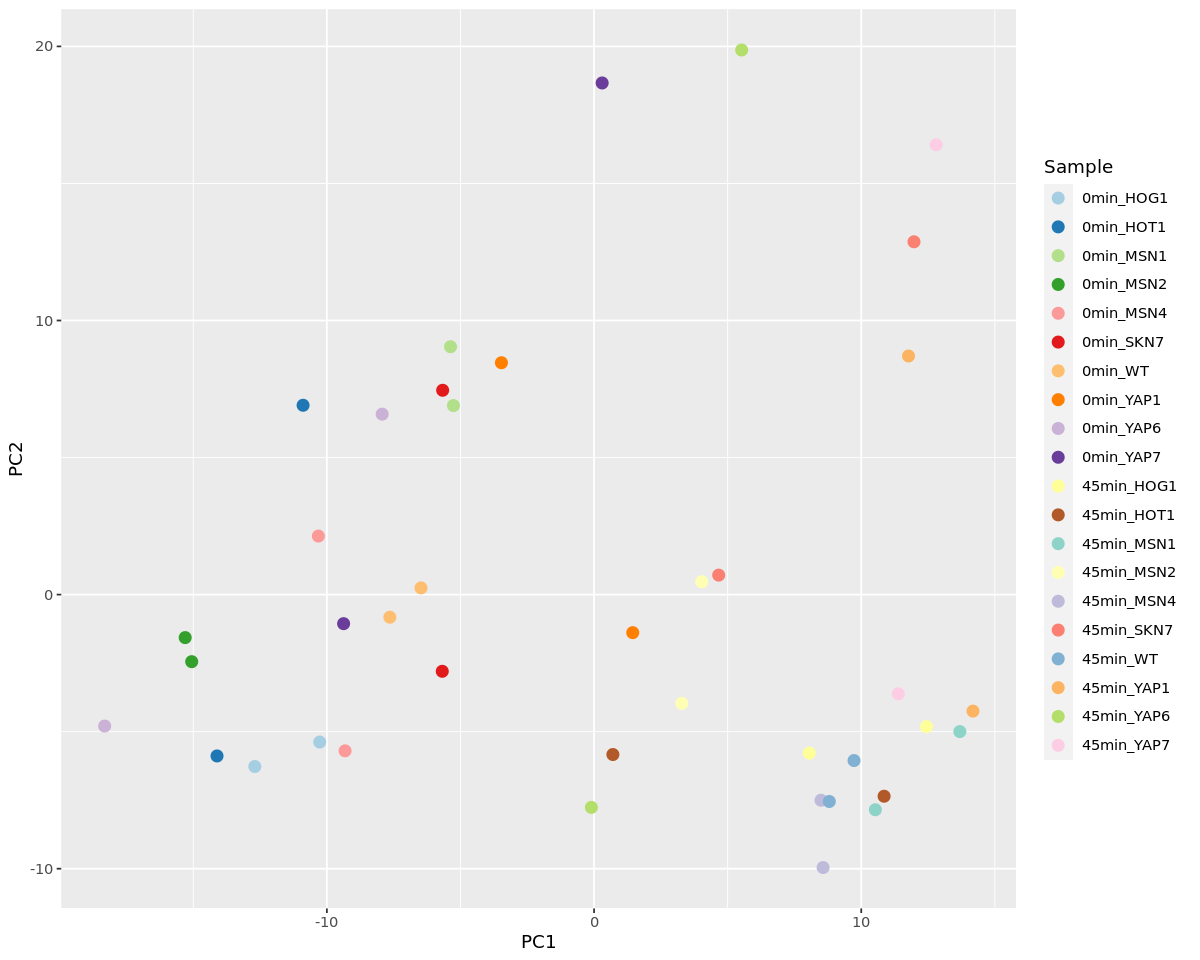

In [61]:
#Plot pc1 vs pc2, color by Sample -- that is, all replicates for the same sample should be the same color. 
ggplot(data=pcs_annotated,
       aes(x=PC1,y=PC2,color=Sample))+
       geom_point(size=3)+
       scale_color_manual(values=cols)


We should see replicates of the same sample clustering close together. Do we see this in the scatterplot above?

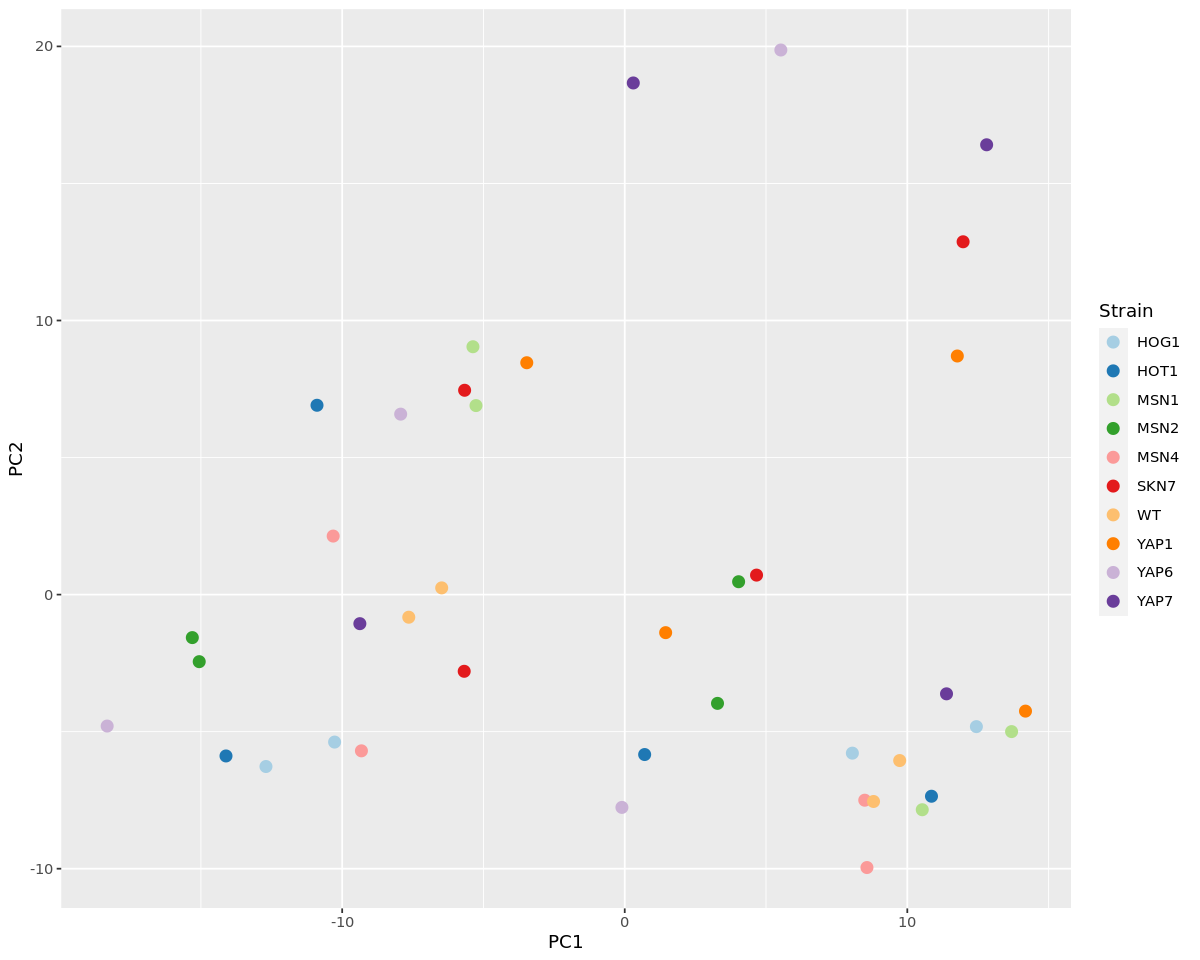

In [62]:
#Plot pc1 vs pc2, color by Strain 
ggplot(data=pcs_annotated,aes(x=PC1,y=PC2,color=Strain))+
geom_point(size=3)+
scale_color_manual(values=cols)


No clear clustering by strain is observed. Let's color by Timepoint

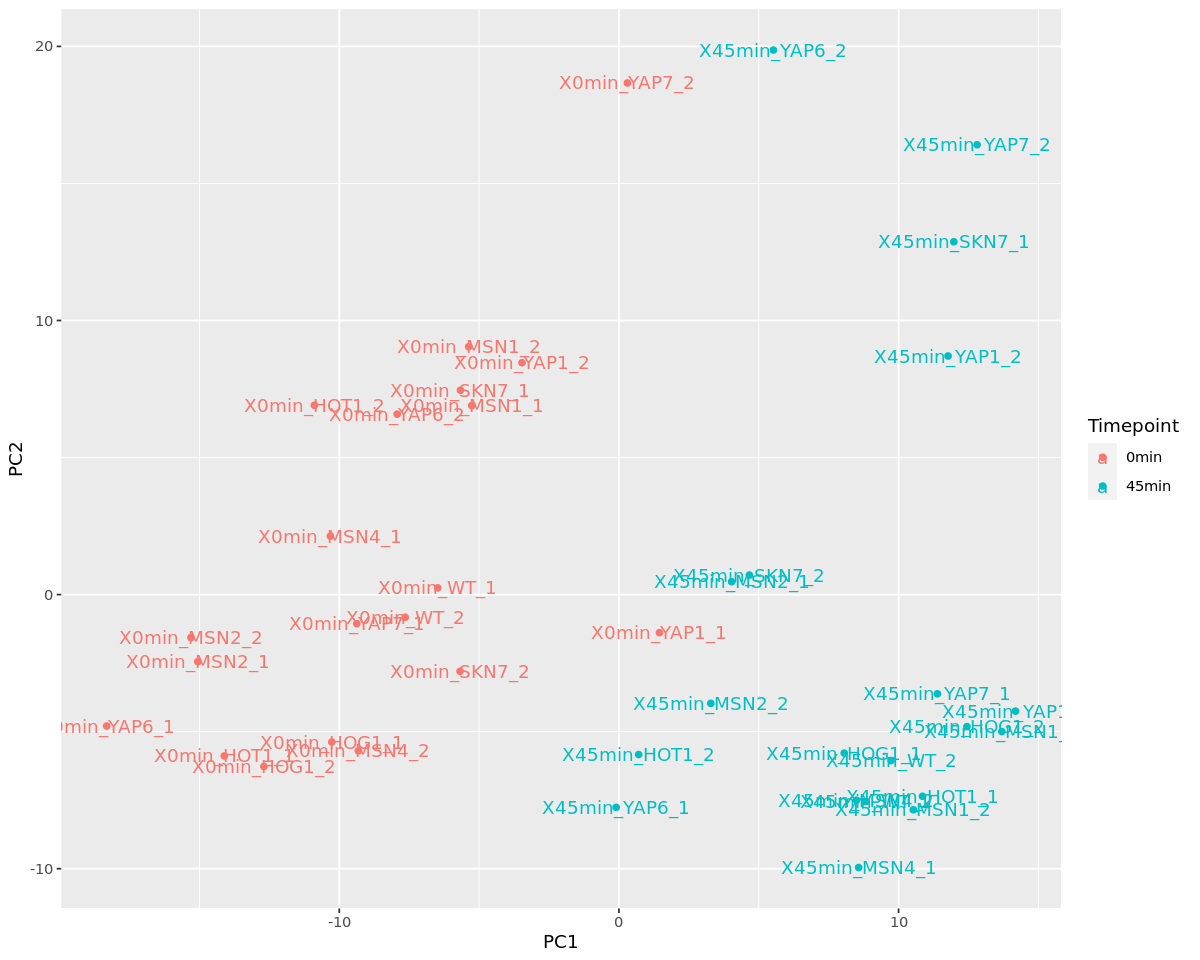

In [63]:
ggplot(data=pcs_annotated,aes(x=PC1,y=PC2,color=Timepoint,label=ID))+
geom_point()+
geom_text()

### Correcting for batch effects ###

We check for batch effects from Researcher and Group. 

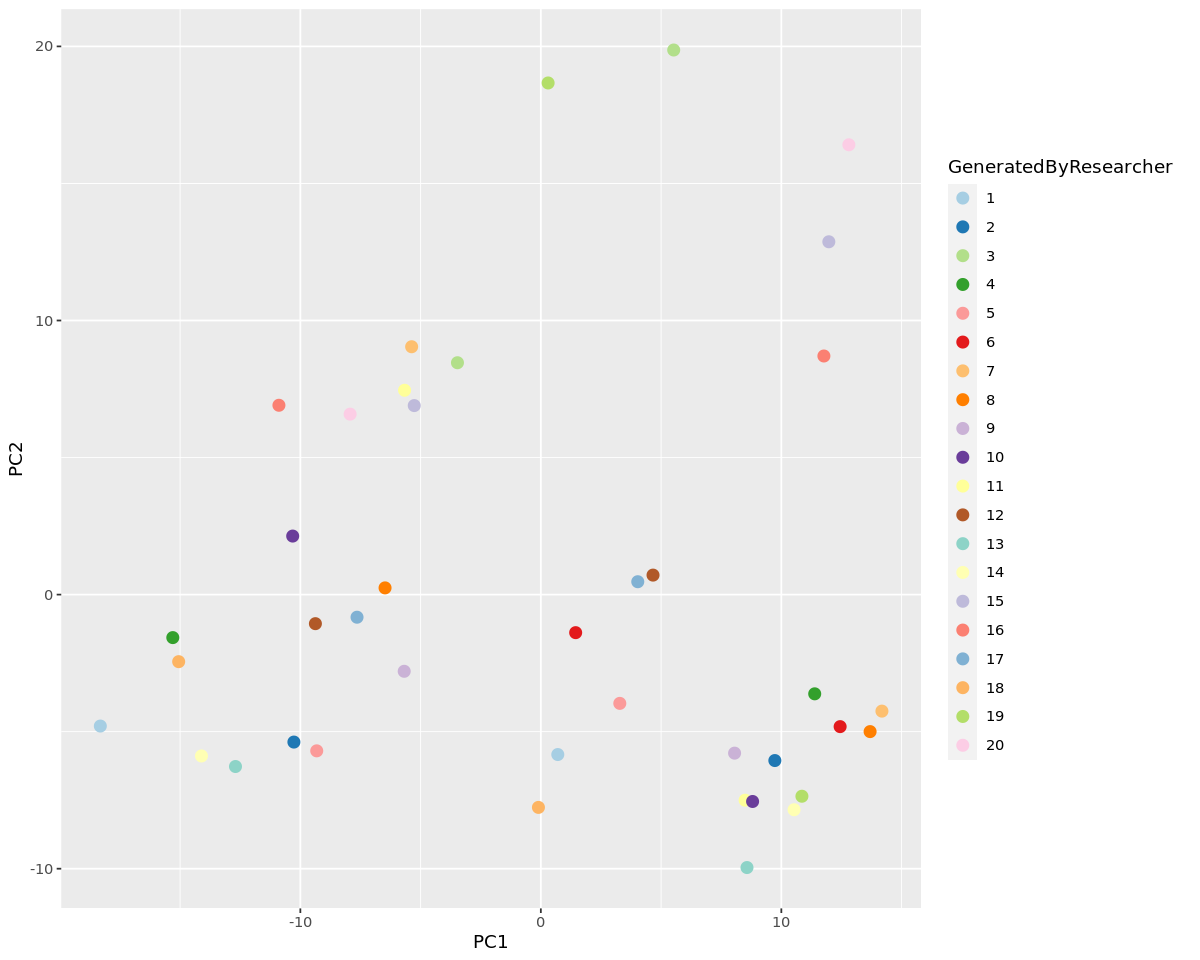

In [64]:
#Plot pc1 vs pc2, color by Researcher -- here, we're checking for a batch effect based on researcher.
ggplot(data=pcs_annotated,aes(x=PC1,y=PC2,color=GeneratedByResearcher))+
geom_point(size=3)+
scale_color_manual(values=cols)



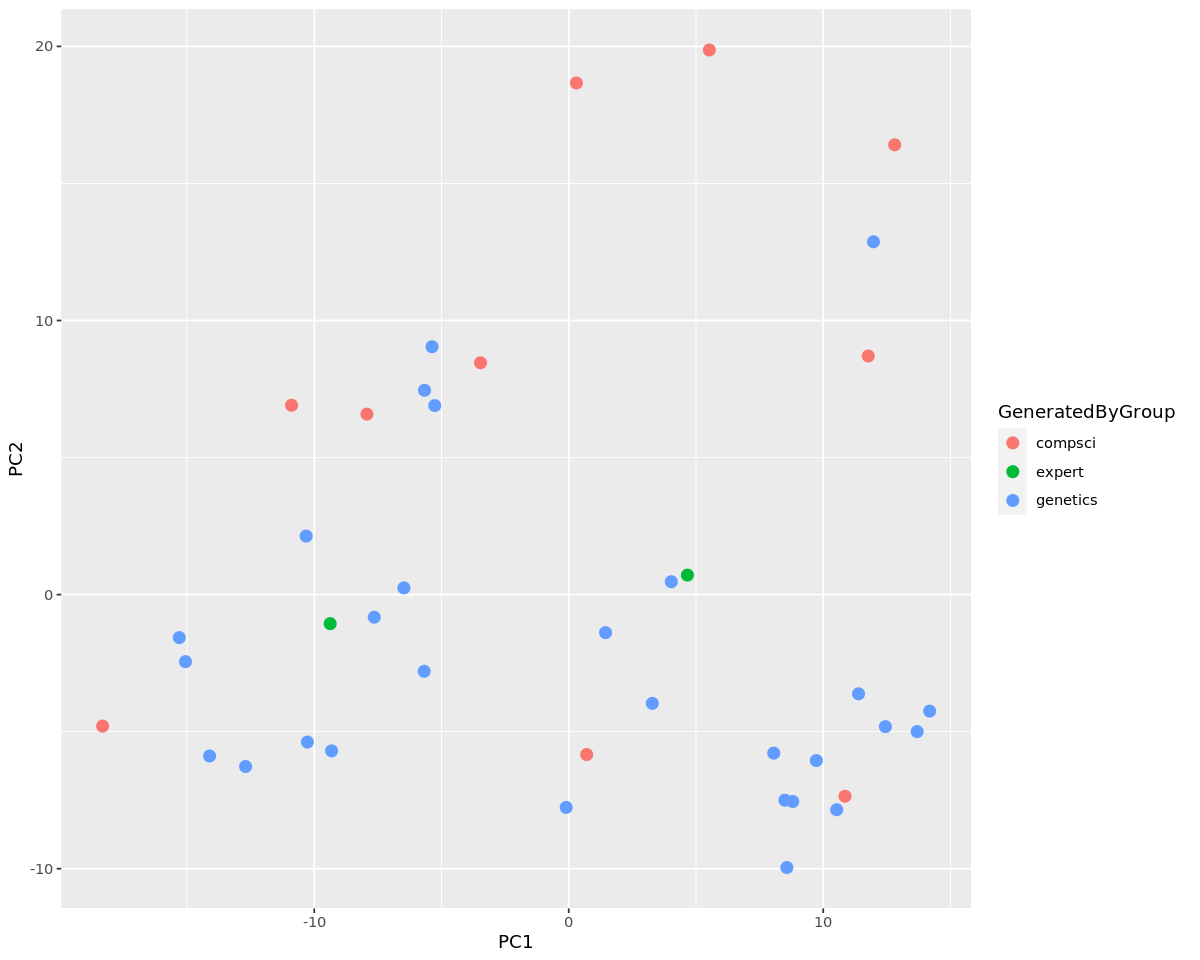

In [65]:
#Plot pc1 vs pc2, color by Researcher -- here, we're checking for a batch effect based on researcher.
ggplot(data=pcs_annotated,aes(x=PC1,y=PC2,color=GeneratedByGroup))+
geom_point(size=3)

We don't see a clear batch effect for any individual researcher who generated the data, but we do observe a batch effect based on the discipline of the researcher -- computational biologists's samples separate from geneticists' samples along PC2. In this case, unfortunately we cannot correct for the "GeneratedByGroup" batch effect, as the design is confounded for the "GeneratedByGroup" variable. However, we can try to correct for any "GeneratedByResearcher" batch effect, even though it's not 100% clear if there is one.  We use the R **limma** package to fit a linear mixed effects model. The explanatory variables are Strain, Timepoint, and  GeneratedByResearcher. The output variable is the normalized count value in the data matrix. We then subtract out the contribution from "GeneratedByResearcher" (the confounding variable) to the output variable. 

In [66]:
library(limma)

In [67]:
#make sure the row order of the metadata file matches the column order of the count_data_matrix file. 
rownames(metadata)=metadata$ID
metadata=metadata[colnames(norm_asinh_count),]


In [68]:
#design the model using entries from our metadata file 
mod=model.matrix(~0+Strain +Timepoint+GeneratedByResearcher,data=metadata)

#fit the model to the data 
fit=lmFit(norm_asinh_count,design=mod)

head(coefficients(fit))



,StrainHOG1,StrainHOT1,StrainMSN1,StrainMSN2,StrainMSN4,StrainSKN7,StrainWT,StrainYAP1,StrainYAP6,StrainYAP7,⋯,GeneratedByResearcher11,GeneratedByResearcher12,GeneratedByResearcher13,GeneratedByResearcher14,GeneratedByResearcher15,GeneratedByResearcher16,GeneratedByResearcher17,GeneratedByResearcher18,GeneratedByResearcher19,GeneratedByResearcher20
chrI 13 555,5.554145,5.581202,5.250266,5.423891,5.612049,5.349627,5.448658,4.779146,5.382399,5.444234,⋯,-0.15071844,-0.1136587,-0.200868885,-0.13770102,-0.1930536,0.03062427,-0.4171030,0.007191342,-1.01014321,-0.93595124
chrI 6348 6518,3.476660,3.101977,3.396226,3.455746,3.558820,3.332285,4.015728,3.372918,3.409116,3.191779,⋯,-0.03637973,0.2552803,-0.003849594,0.40779531,-0.2326450,-0.07705927,-0.2900990,0.126968647,0.23798774,-0.09804463
chrI 9278 9407,2.828554,2.172150,2.644587,2.288343,2.981563,3.048932,2.261240,1.661676,3.018771,2.479154,⋯,-1.46947700,-1.3228836,-1.178888561,-0.82647095,-0.5009356,0.30119663,-0.3532757,-0.862990836,-0.96071200,0.08088048
chrI 19401 19705,3.005312,2.243704,2.165906,2.417938,2.272535,2.817355,2.461867,2.727481,2.187735,2.403461,⋯,0.14497104,-0.4576221,-0.913088882,-0.75343007,1.1863663,-0.09458982,0.2423972,-0.607157906,0.17173755,0.84454219
chrI 20461 21224,5.559617,5.530196,5.297818,5.244053,5.492220,5.470283,5.485061,5.820857,5.218503,5.130592,⋯,-0.21490741,0.1373547,-0.047610424,-0.11186683,-0.1245431,0.11397580,-0.0963362,0.126266344,-0.03547685,0.36747821
chrI 28565 28910,4.337217,4.485350,3.947347,5.121889,4.485200,3.612303,4.727297,4.544622,4.641655,4.518653,⋯,0.27579712,-0.6326054,0.167242557,-0.02168664,0.8363053,0.22031813,-0.5267011,-0.105923277,-0.21635861,-0.26954123


In [69]:
colnames(fit$design)


[1] "StrainHOG1"              "StrainHOT1"             
 [3] "StrainMSN1"              "StrainMSN2"             
 [5] "StrainMSN4"              "StrainSKN7"             
 [7] "StrainWT"                "StrainYAP1"             
 [9] "StrainYAP6"              "StrainYAP7"             
[11] "Timepoint45min"          "GeneratedByResearcher2" 
[13] "GeneratedByResearcher3"  "GeneratedByResearcher4" 
[15] "GeneratedByResearcher5"  "GeneratedByResearcher6" 
[17] "GeneratedByResearcher7"  "GeneratedByResearcher8" 
[19] "GeneratedByResearcher9"  "GeneratedByResearcher10"
[21] "GeneratedByResearcher11" "GeneratedByResearcher12"
[23] "GeneratedByResearcher13" "GeneratedByResearcher14"
[25] "GeneratedByResearcher15" "GeneratedByResearcher16"
[27] "GeneratedByResearcher17" "GeneratedByResearcher18"
[29] "GeneratedByResearcher19" "GeneratedByResearcher20"

In [70]:
#We note that column 5 in the model captures the batch effect from the "Researcher" variable. We can remove the 
#contribution of this variable from the data: 
batch_contribution=coefficients(fit)[,12:29]%*% t(fit$design[,12:29])
norm_asinh_count_corrected=norm_asinh_count-batch_contribution

Let's re-run the PCA analysis on  count_data_matrix_corrected to make sure we're no longer observing a batch effect 
due to researcher.



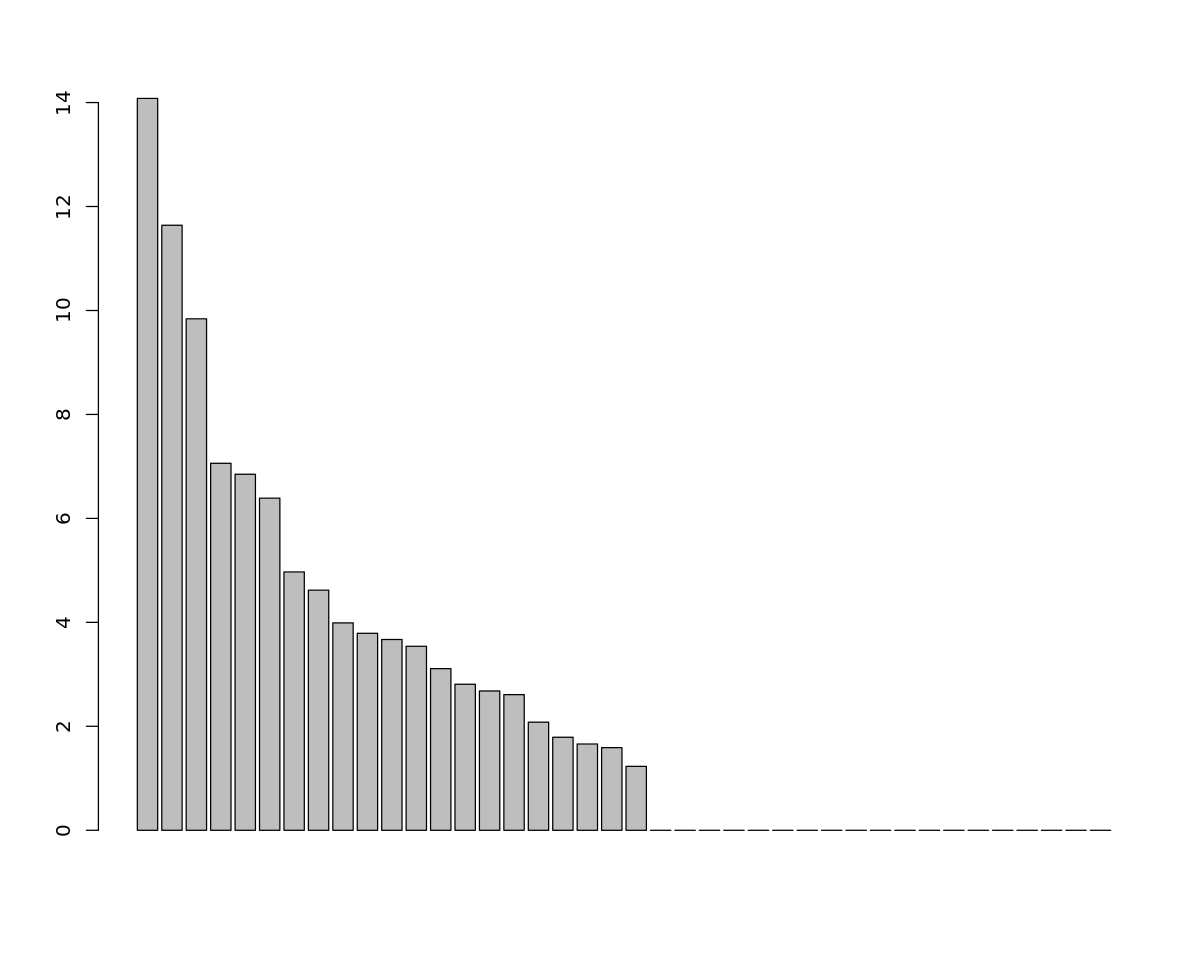

In [71]:
count.pca.corrected=prcomp(t(norm_asinh_count_corrected))
var_explained=round(100*count.pca.corrected$sdev^2/sum(count.pca.corrected$sdev^2),2)
barplot(var_explained)
pcs.corrected=data.frame(count.pca.corrected$x)
pcs.corrected$ID=rownames(pcs.corrected)
pcs_annotated.corrected=merge(pcs.corrected,metadata,by="ID")

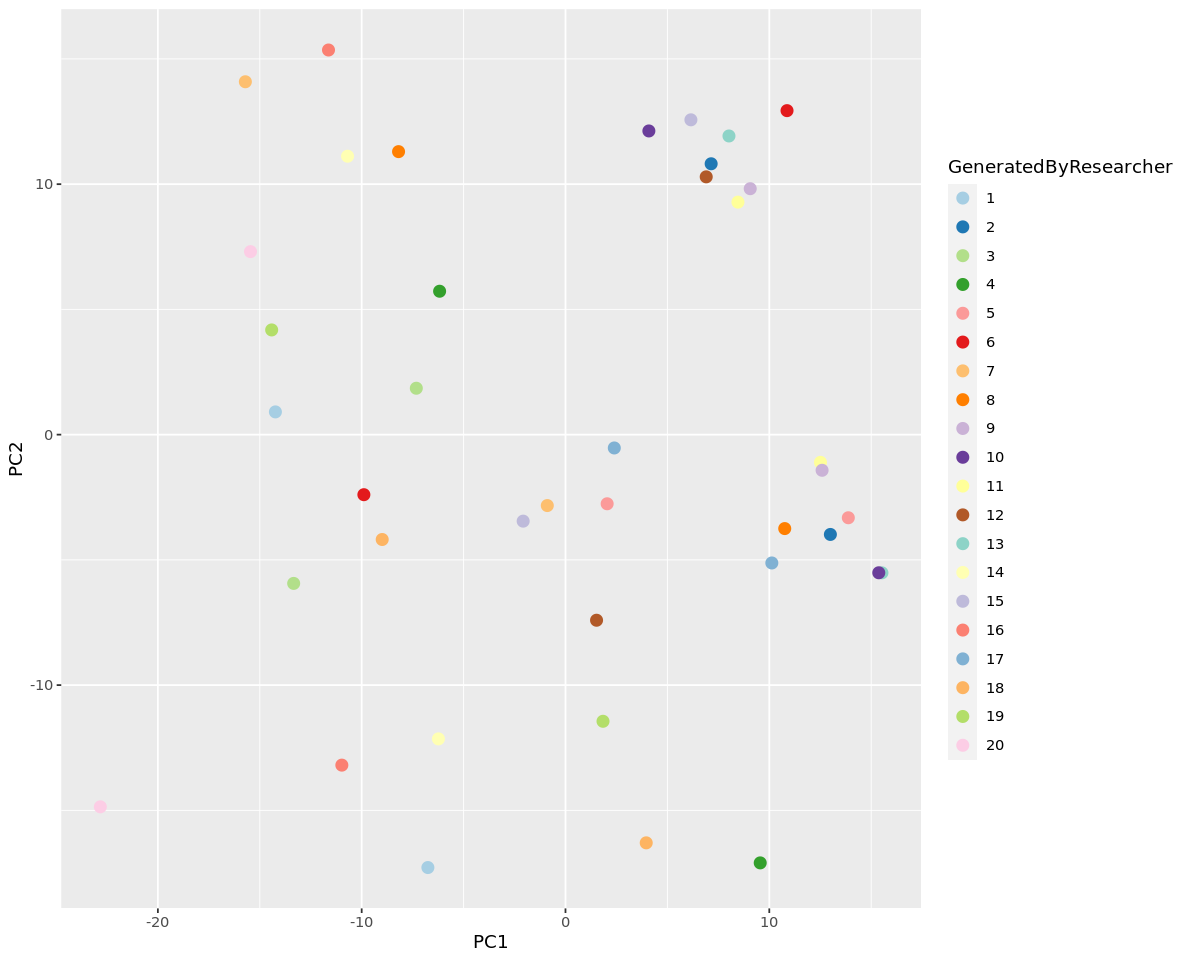

In [72]:
ggplot(data=pcs_annotated.corrected,
       aes(x=PC1,y=PC2,color=GeneratedByResearcher))+
       geom_point(size=3)+
       scale_color_manual(values=cols)

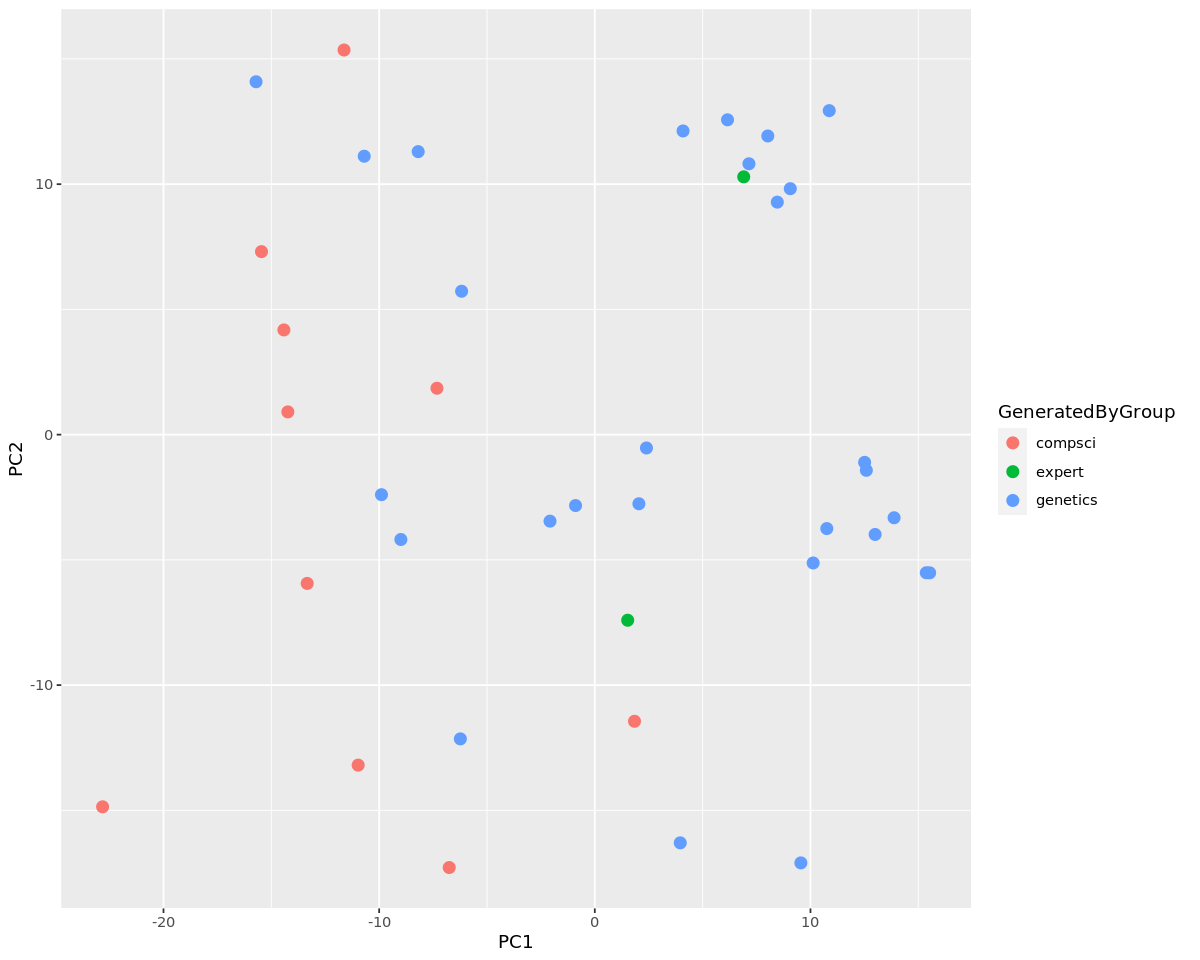

In [73]:
ggplot(data=pcs_annotated.corrected,
       aes(x=PC1,y=PC2,color=GeneratedByGroup))+
       geom_point(size=3)

We see less spread between geneticists' and comp sci samples, though there is still some clustering.   Let's make sure that the samples still separate by Timepoint and check for any improved separation by Strain. 

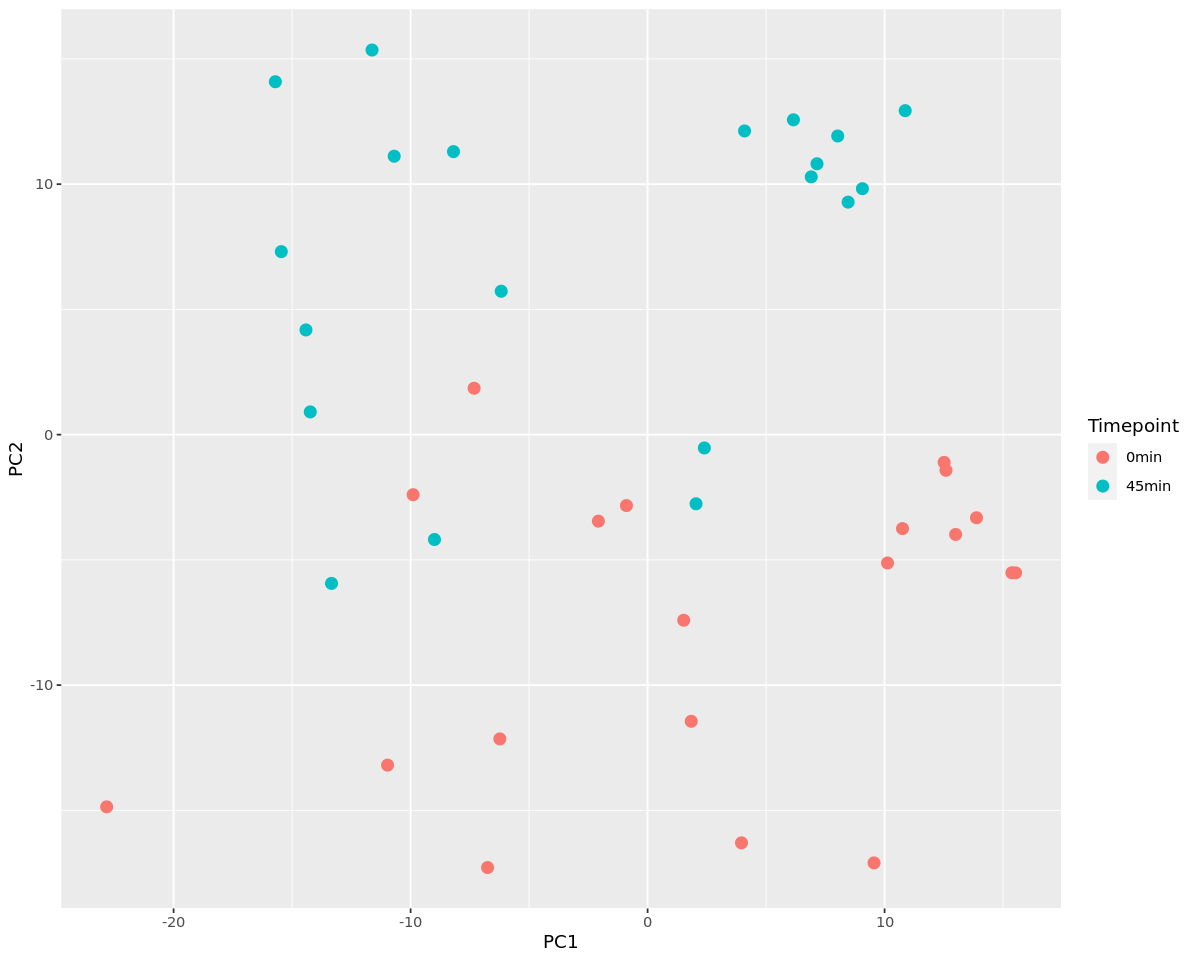

In [74]:
ggplot(data=pcs_annotated.corrected,aes(x=PC1,y=PC2,color=Timepoint))+
geom_point(size=3)

Let's check for separation by Strain:

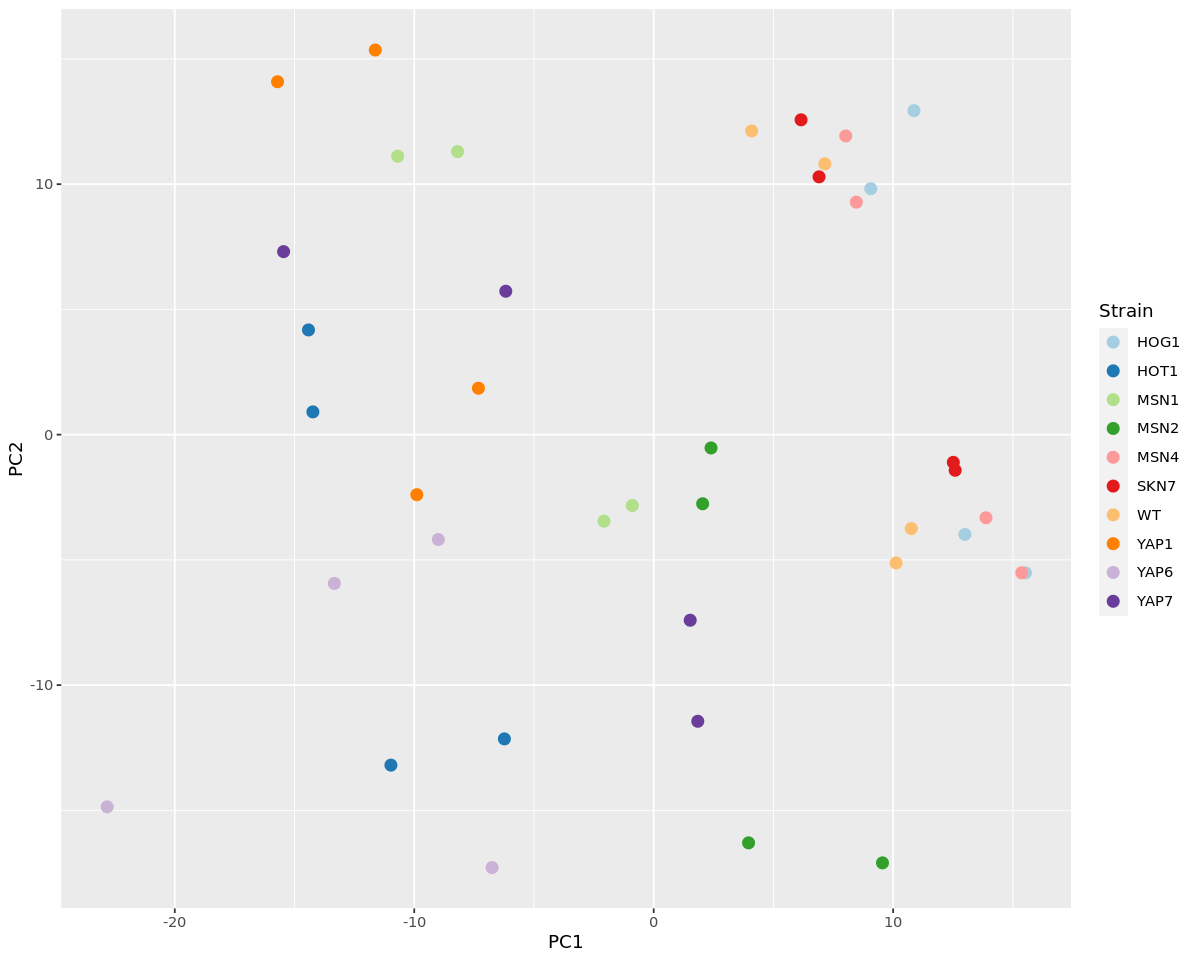

In [75]:
ggplot(data=pcs_annotated.corrected,aes(x=PC1,y=PC2,color=Strain))+
geom_point(size=3)+
scale_color_manual(values=cols)

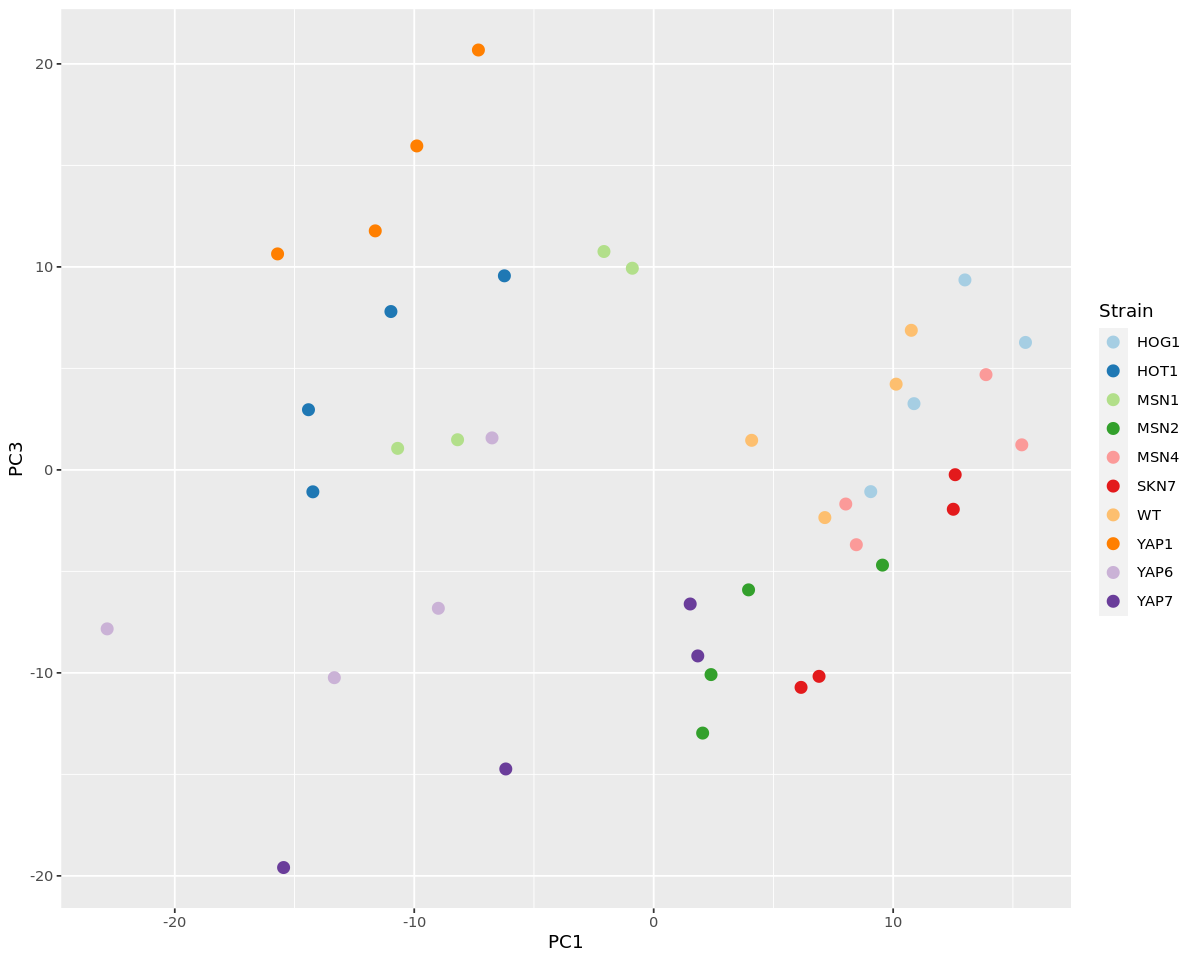

In [76]:
ggplot(data=pcs_annotated.corrected,aes(x=PC1,y=PC3,color=Strain))+
geom_point(size=3)+
scale_color_manual(values=cols)

#### Getting peak contributions to principal components. ####

Finally, we'd like to determine how much each peak contributes to PC1, PC2, and PC3. We can look at PC4 and up also, but for the sake of time we'll stick with the first 3 principal components; from the scree plot, we see they explain approximately 50% of the variance in the data. Primarily we want to get a sense of which peaks are critical in defining the principle components, and in which direction (positive or negative).

In [77]:
contribs_pc1=sort(count.pca.corrected$rotation[,1])
contribs_pc2=sort(count.pca.corrected$rotation[,2])
contribs_pc3=sort(count.pca.corrected$rotation[,3])

#these are lists of contributs from each peak to the corresponding PC
tail(contribs_pc1)
length(contribs_pc1)

chrX\t68498\t68601  chrXII\t254679\t254823 chrXV\t1017850\t1017950 
             0.04847740              0.04883848              0.04886351 
   chrV\t397279\t397352     chrXV\t80780\t80972     chrII\t46213\t46361 
             0.05213126              0.05392473              0.06049135

[1] 4804

In [78]:
#Use the write.table command to write the PC contribution data to output files. 

write.table(contribs_pc1,paste(work_dir,"pc1_contribs.txt",sep='/'),quote=FALSE,col.names=FALSE,row.names=TRUE,sep='\t')
write.table(contribs_pc2,paste(work_dir,"pc2_contribs.txt",sep='/'),quote=FALSE,col.names=FALSE,row.names=TRUE,sep='\t')
write.table(contribs_pc3,paste(work_dir,"pc3_contribs.txt",sep='/'),quote=FALSE,col.names=FALSE,row.names=TRUE,sep='\t')


## Hierarchical Clustering of Count Signal Across Samples ##

Cluster analysis is a simple way to visualize patterns in the data. By clustering peaks according to their signal across different time points, we may find groups of peaks that have similar behavior across these time points. By clustering samples according to their signal across peaks, we can perform a simple sanity check of data quality ‐ samples of the same time point should cluster together.

In [79]:
library(gplots)
library(RColorBrewer)


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




In [80]:
?dist

In [81]:
?hclust


Let's begin by clustering normalized count data that has not been corrected for the sample swap or the batch effect:

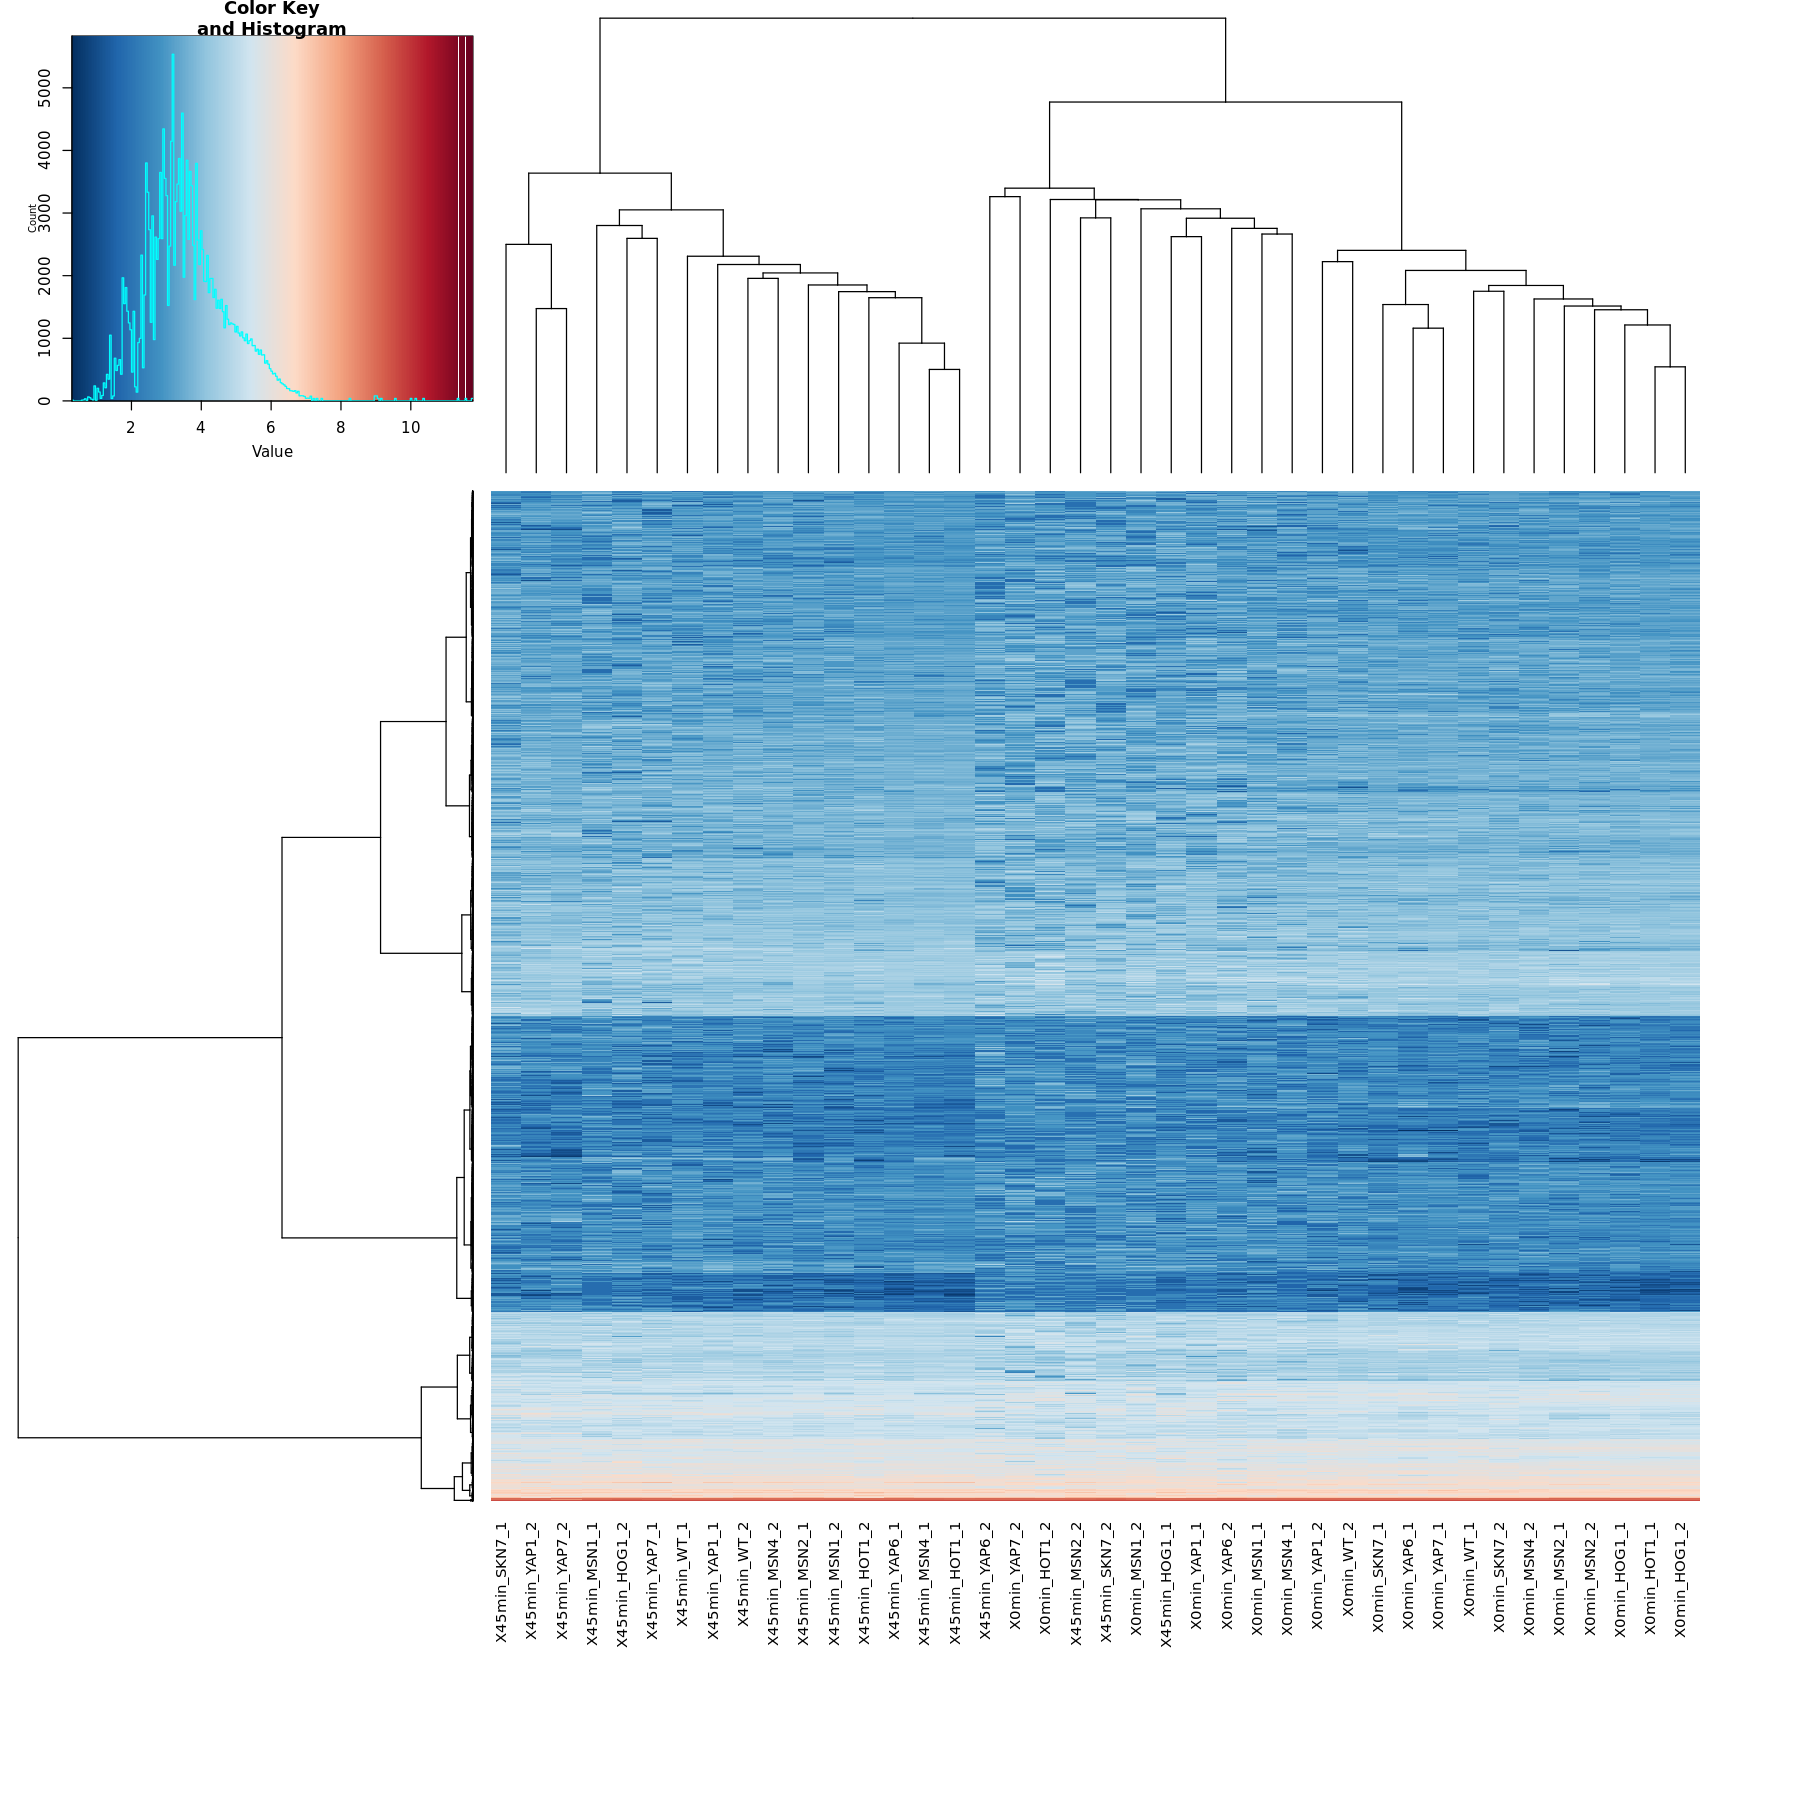

In [82]:
##let's increase plot size so we can examine the heatmap more clearnly
options(repr.plot.width=15, repr.plot.height=15)
heatmap.2(norm_asinh_count,
          scale     = "none",
          col       = rev(colorRampPalette(brewer.pal(10, "RdBu"))(256)),
          distfun   = function(x) dist(x,method="euclidean"),
          hclustfun = function(x) hclust(x, method="ward.D"),
          Rowv=TRUE,
          Colv=TRUE,
          trace="none",
          cexCol = 0.9,
          margins=c(15,5),
          labRow="")



Now, we examine the hierarchical clustering on the corrected count data. 

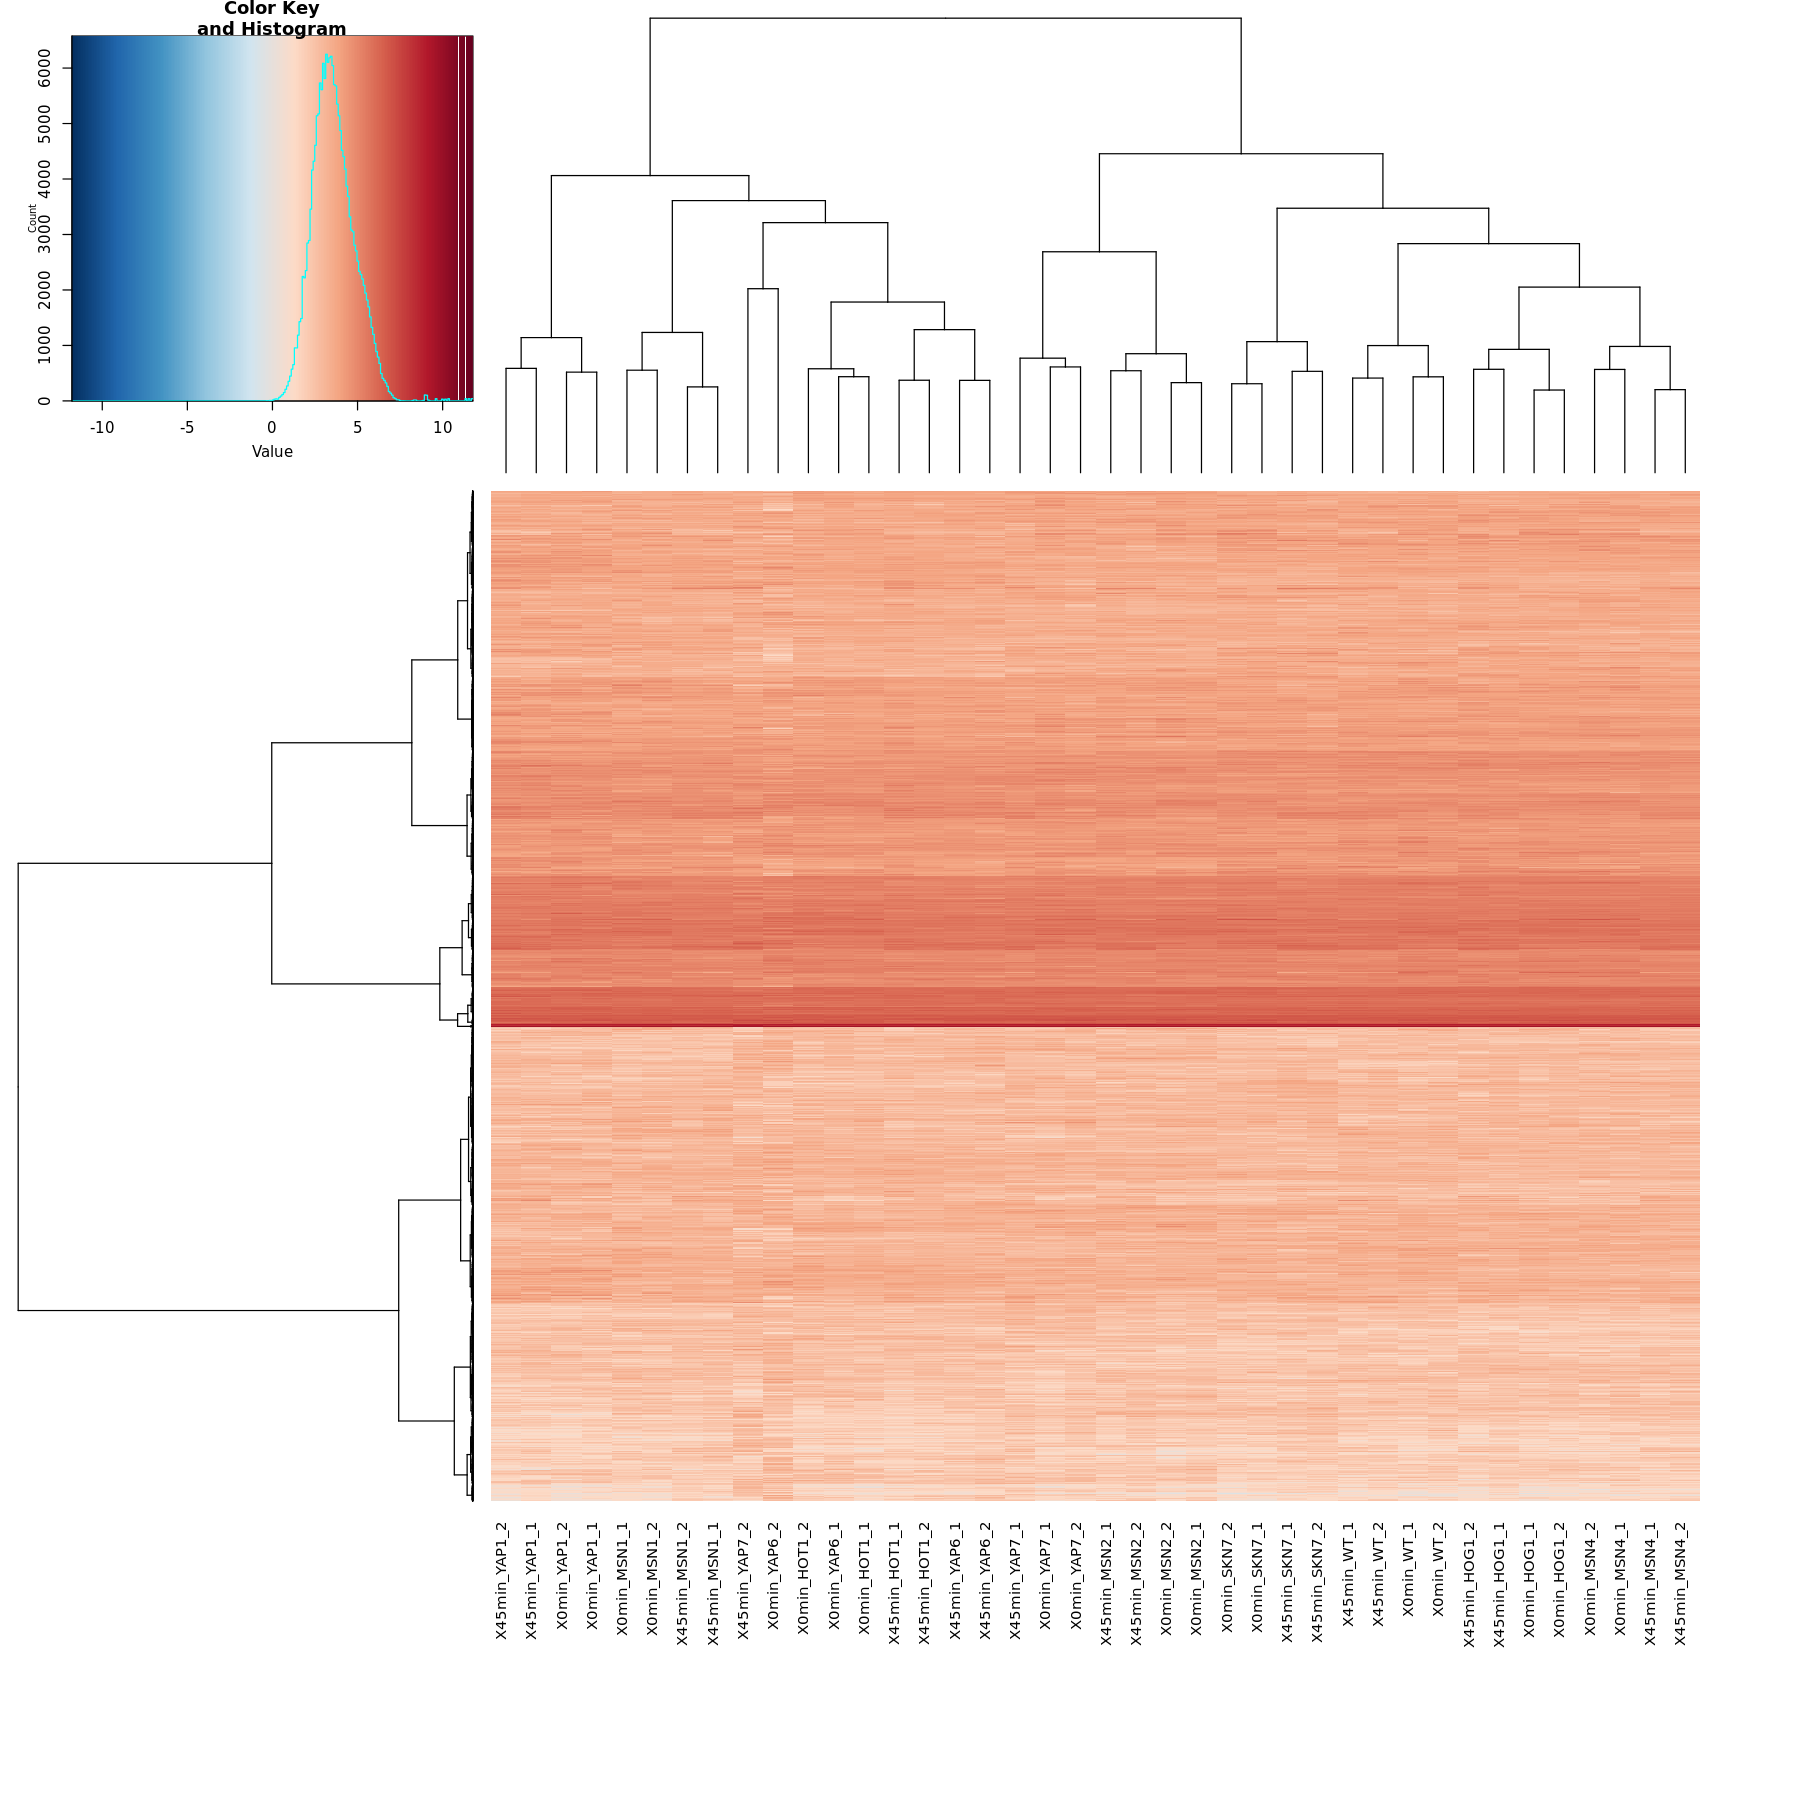

In [83]:
heatmap.2(norm_asinh_count_corrected,
          scale     = "none",
          col       = rev(colorRampPalette(brewer.pal(10, "RdBu"))(256)),
          distfun   = function(x) dist(x,method="euclidean"),
          hclustfun = function(x) hclust(x, method="ward.D"),
          Rowv=TRUE,
          Colv=TRUE,
          trace="none",
          cexCol = 0.9,
          margins=c(15,5),
          labRow="")


There is very little contrast in the heatmap that was generated. We can add contrast by modifying how "breaks" between colors are generated. 

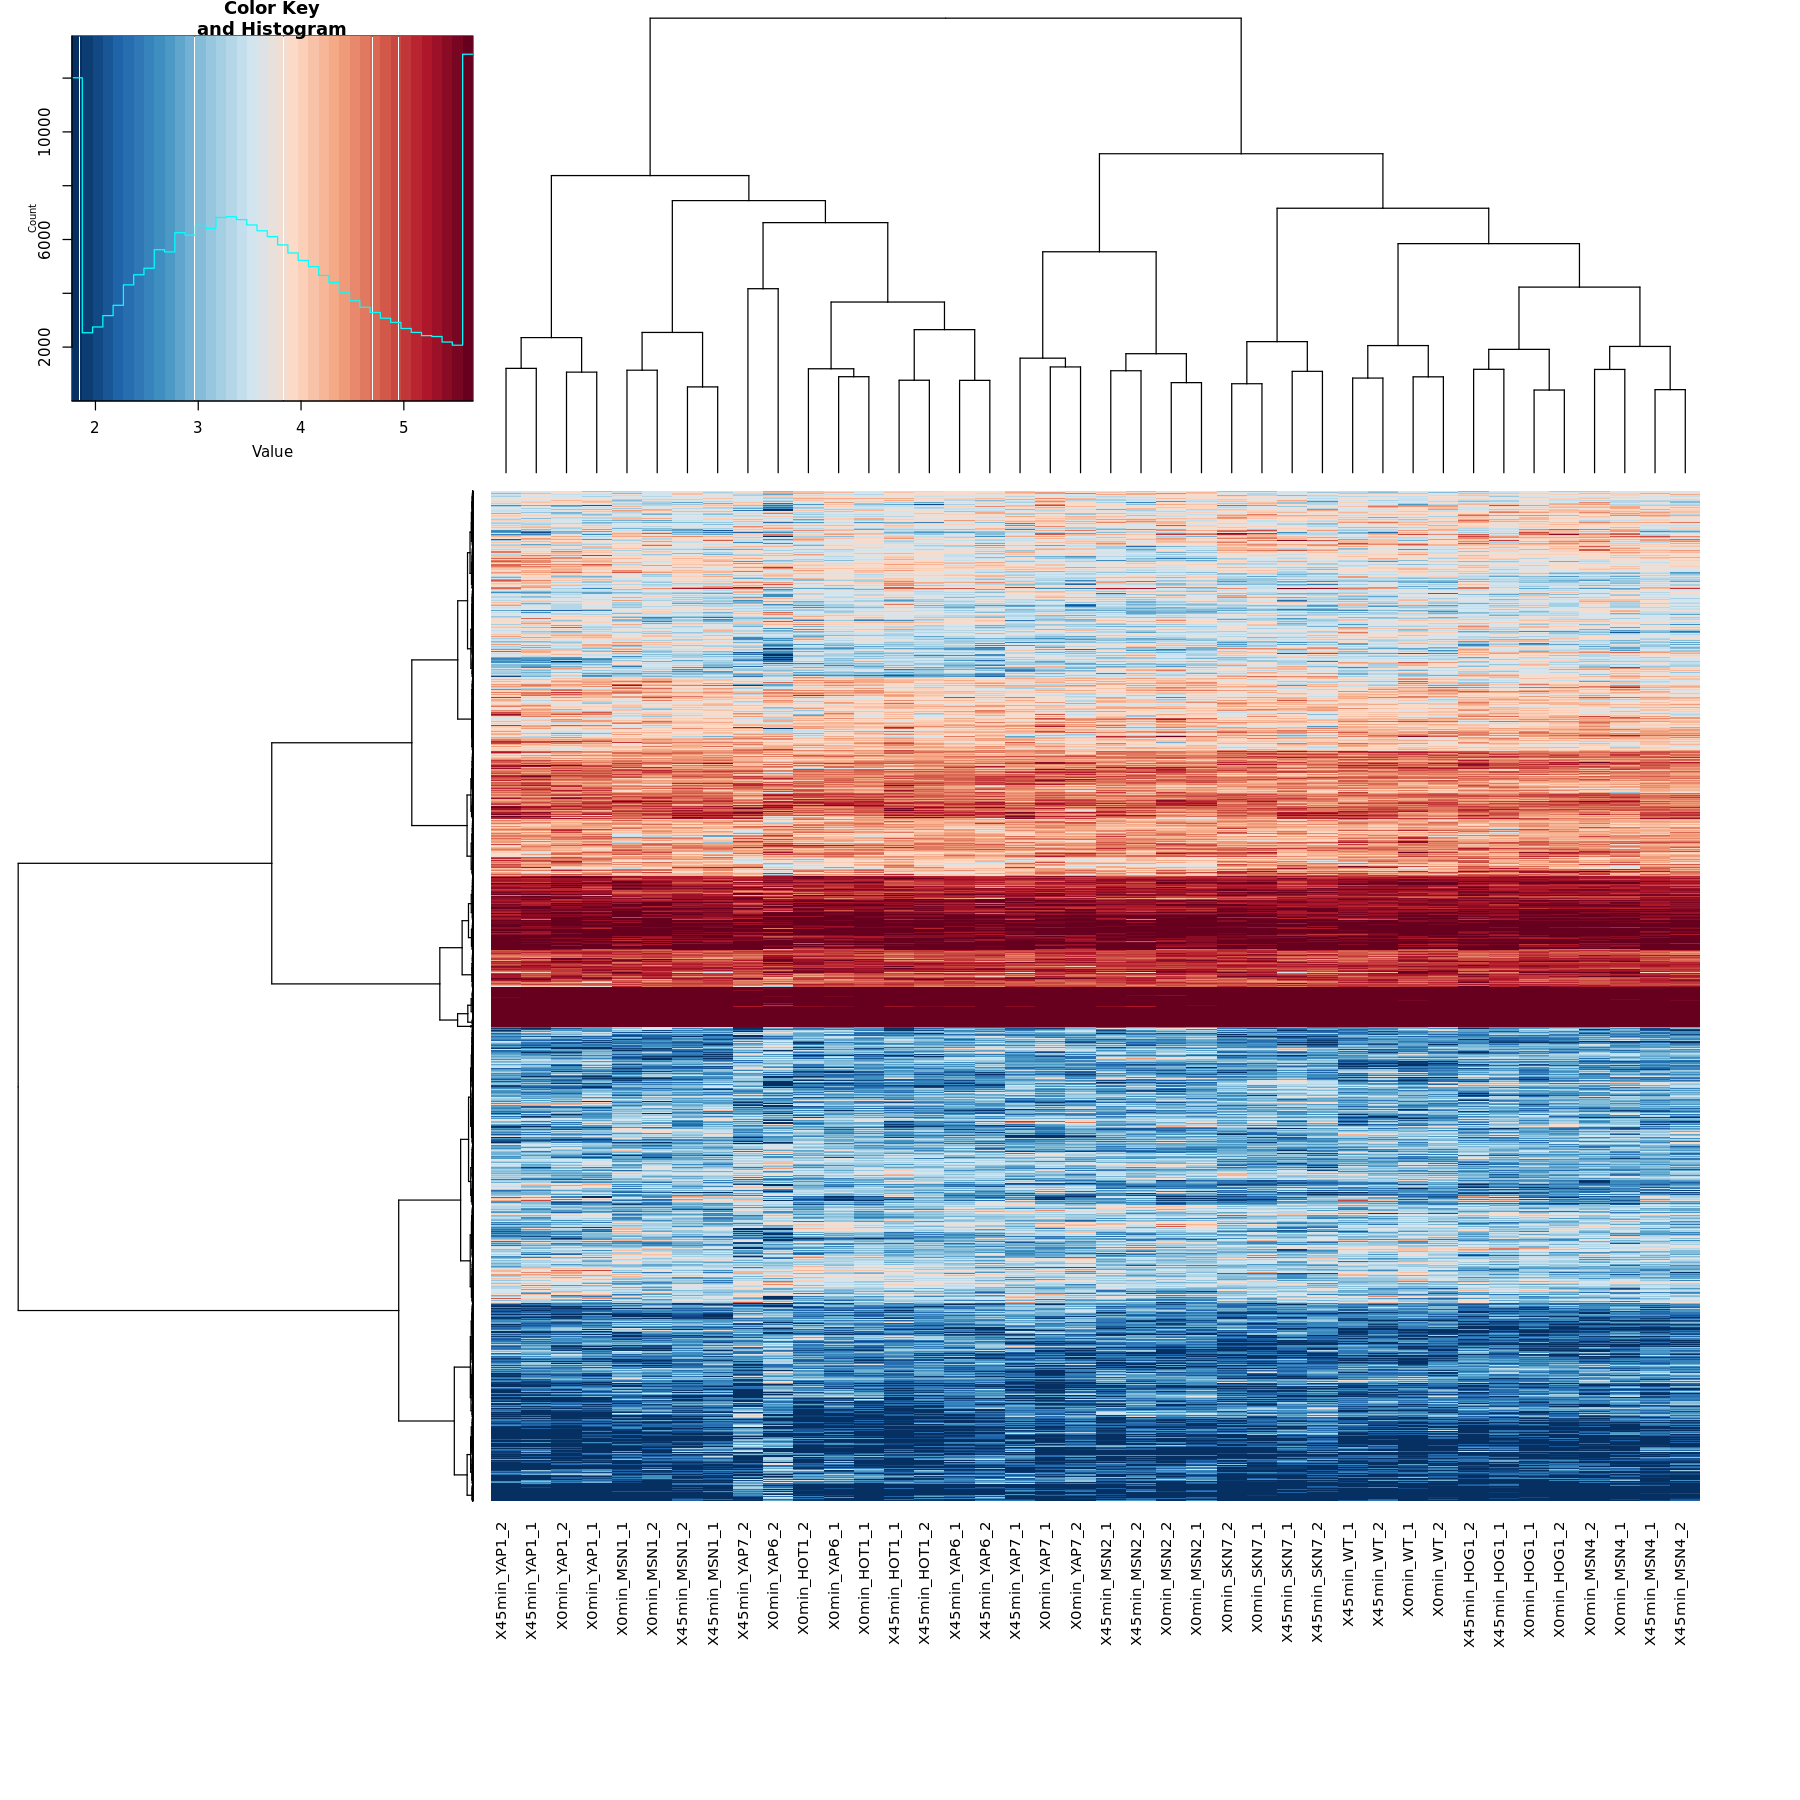

In [84]:
#We split the count matrix into 1% quantiles 
quantile.range <- quantile(norm_asinh_count_corrected, probs = seq(0, 1, 0.01))
#we scale the breaks in the heatmap color palette according to the quantiles. 
palette.breaks <- seq(quantile.range["5%"], quantile.range["95%"], 0.1)


heatmap.2(norm_asinh_count_corrected,
          scale     = "none",
          col       = rev(colorRampPalette(brewer.pal(10, "RdBu"))(length(palette.breaks) - 1)),
          distfun   = function(x) dist(x,method="euclidean"),
          hclustfun = function(x) hclust(x, method="ward.D"),
          Rowv=TRUE,
          Colv=TRUE,
          trace="none",
          cexCol = 0.9,
          margins=c(15,5),
          breaks = palette.breaks,
          labRow="")


The two heatmaps look very different, but show the same data! 
When selecting a color scheme for PCA or heatmaps in R, the R Color Brewer tool is quite useful. Also, for nice color palettes, check out: http://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3